# Benchmark Round Trip time experiment (Switch)
This notebook will show you how to measure the round trip time between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

## Source Dask device and utilities

In this section we will import the libraries and dask on pynq class which allow us to:

* Download a `xclbin` file to a worker
* Peek and poke registers
* Allocate buffers
* Start kernels

All of these capabilities are available for both local and remote workers

In [35]:
from vnx_utils import *
import pynq

## Download xclbin to workers
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [36]:
workers = pynq.Device.devices
workers

In [37]:
xclbin = '/home/ubuntu/Projects/StaRR-NIC/xup_vitis_network_example/benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=workers[0])

## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between the two Alveo cards is established.

In [38]:
print("Link worker 0_0 {}, worker 0_1 {}".format(ol_w0.cmac_0.linkStatus(), ol_w0.cmac_1.linkStatus()))

Link worker 0_0 {'cmac_link': True}, worker 0_1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [61]:
ip_w0_0, ip_w0_1 = '10.0.0.47', '10.0.0.45'
if_status_w0_0 = ol_w0.networklayer_0.updateIPAddress(ip_w0_0, debug=True)
if_status_w0_1 = ol_w0.networklayer_0.updateIPAddress(ip_w0_1, debug=True)
print("Worker 0_0: {}\nWorker 0_1: {}".format(if_status_w0_0, if_status_w0_1))

Worker 0_0: {'HWaddr': '00:0a:35:02:9d:2f', 'inet addr': '10.0.0.47', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}
Worker 0_1: {'HWaddr': '00:0a:35:02:9d:2d', 'inet addr': '10.0.0.45', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}


### Remote params

In [62]:
src_port, dst_port = 60512, 62176
dst_ip = '10.0.0.53'
dst_ip2 = '10.0.0.55'
dst_mac = '00:0a:35:d1:6b:ce'
dst_mac2 = '00:0a:35:6d:cc:d5'

### Configure local Alveo

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [63]:
ol_w0.networklayer_0.sockets[2] = (dst_ip, dst_port, src_port, True)
ol_w0.networklayer_0.populateSocketTable()

ol_w0.networklayer_0.arpDiscovery()

ol_w0.networklayer_0.readARPTable()

{53: {'MAC address': '00:0a:35:d1:6b:ce', 'IP address': '10.0.0.53'},
 55: {'MAC address': '00:0a:35:6d:cc:d5', 'IP address': '10.0.0.55'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

In [64]:
ol_w0.networklayer_0.write_arp_entry(dst_mac, dst_ip)
ol_w0.networklayer_0.readARPTable()

{53: {'MAC address': '00:0a:35:d1:6b:ce', 'IP address': '10.0.0.53'},
 55: {'MAC address': '00:0a:35:6d:cc:d5', 'IP address': '10.0.0.55'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

## Configure application

### Configure local benchmark application
This part configures the collector, in particular
* Allocate buffers
* Start collector

In [69]:
send_packets   = 2 ** 20
shape          = (send_packets,1)
rtt_cycles     = pynq.allocate(shape, dtype=np.uint32, target=ol_w0.HBM0)
pkt            = pynq.allocate(1,     dtype=np.uint32, target=ol_w0.HBM0)

collector_h = ol_w0.collector_0_2.start(rtt_cycles,pkt)


**This part configures the traffic generator** `traffic_generator_0_2`

In [70]:
send_pkts = send_packets
ol_w0_tg = ol_w0.traffic_generator_0_2
ol_w0_tg.register_map.debug_reset = 1
ol_w0.networklayer_0.register_map.debug_reset_counters = 1
ol_w0_tg.register_map.mode = benchmark_mode.index('LATENCY')
ol_w0_tg.register_map.number_packets = send_pkts
ol_w0_tg.register_map.time_between_packets = 50
ol_w0_tg.register_map.number_beats = 1
ol_w0_tg.register_map.dest_id = 2
ol_w0_tg.register_map.CTRL.AP_START = 1

## Read latency result
* Call the dask method to synchronize the Alveo buffer with the dask buffer

Note that this buffer contains the round trip time in clock cycles

In [71]:
rtt_cycles.sync_from_device()
rtt_cycles

PynqBuffer([[0],
            [0],
            [0],
            ...,
            [0],
            [0],
            [0]], dtype=uint32)

## Compute some statistics on the results
1. Convert the rtt from cycles to microseconds, get clock frequency by querying `.clock_dict['clock0']['frequency']`

In [58]:
freq = int(ol_w0.clock_dict['clock0']['frequency'])
rtt_usec = np.array(shape, dtype=np.float)
rtt_usec= rtt_cycles / freq  # convert to microseconds

/tmp/ipykernel_33124/149005877.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rtt_usec = np.array(shape, dtype=np.float)


2. Use `scipy` to compute statistical values
    * Mean
    * Standard deviation
    * Mode

In [59]:
from scipy import stats
mean, std_dev, mode = np.mean(rtt_usec), np.std(rtt_usec), stats.mode(rtt_usec)
print("Round trip time at application level using {:,} packets".format(len(rtt_usec)))
print("\tmean    = {:.3f} us\n\tstd_dev = {:.6f} us".format(mean,std_dev))
print("\tmode    = {:.3f} us, which appears {:,} times".format(mode[0][0][0],mode[1][0][0]))
print("\tmax     = {:.3f} us".format(np.max(rtt_usec)))
print("\tmin     = {:.3f} us".format(np.min(rtt_usec)))

Round trip time at application level using 1,048,576 packets
	mean    = 0.000 us
	std_dev = 0.000000 us
	mode    = 0.000 us, which appears 1,048,576 times
	max     = 0.000 us
	min     = 0.000 us


## Plot Box and whisker graph

/tmp/ipykernel_33124/1664195630.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f205c33a430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f205c33a9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f205c33a160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f205c30d130>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f205c31c9a0>],
 'means': []}

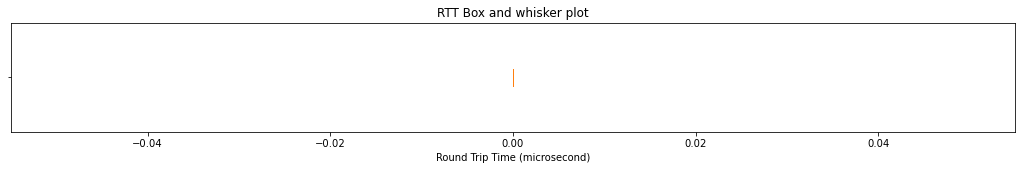

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

red_square = dict(markerfacecolor='r', marker='s')
fig, ax = plt.subplots()
ax.set_title('RTT Box and whisker plot')
ax.set_xlabel('Round Trip Time (microsecond)')
ax.set_yticklabels([''])
fig.set_size_inches(18, 2)
ax.boxplot(rtt_usec, vert=False, flierprops=red_square)

## Release Alveo cards
* To release the alveo cards the pynq overlay is freed
* Delete dask pynq-dask buffers

In [31]:
del rtt_cycles
del pkt
pynq.Overlay.free(ol_w0)

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.